Leaf Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.neighbors import NearestNeighbors

from scipy.stats.stats import pearsonr   

train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

**Data Preparation**

In [2]:
margin_cols = [col for col in train.columns if 'margin' in col]
shape_cols = [col for col in train.columns if 'shape' in col] 
texture_cols = [col for col in train.columns if 'texture' in col] 

In [3]:
label_encoder = LabelEncoder()
classLabel = label_encoder.fit(train.species)
labels = label_encoder.fit_transform(train.species)
classes = list(classLabel.classes_)                    
test_ids = test.id

train_all = train.drop(['species', 'id'], axis=1)
test = test.drop(['id'], axis=1)

scaler = StandardScaler().fit(train_all)
train_all = scaler.transform(train_all)

In [ ]:
type(train_all)

In [4]:
train_margin = train[margin_cols]
train_shape = train[shape_cols]
train_texture = train[texture_cols]
train_margin = train_margin.as_matrix()
train_shape = train_shape.as_matrix()
train_texture = train_texture.as_matrix()

In [5]:
#K-fold with 5  
kfold = KFold(n_splits=5, shuffle=True, random_state=4)

In [6]:
# naive bayse with K-fold cross validation
nb = GaussianNB()
#standardization
#scaler = StandardScaler().fit(train)
#train = scaler.transform(train)
naiveBayseScore = list()
for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    naiveBayse = nb.fit(X_train,y_train)
    naiveBayseScore.append(naiveBayse.score(X_test, y_test))
nb_validation = naiveBayseScore

np.mean(nb_validation)

0.48686868686868684

In [7]:
#linear DiscriminatAnalysis
ld = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage='auto')
linearDiscScore = list()

for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    linearDisc = ld.fit(X_train,y_train)
    linearDiscScore.append(linearDisc.score(X_test, y_test))
ld_validation = linearDiscScore

np.mean(ld_validation)

/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


0.98181818181818181

In [8]:
#KNearestNeighbours
knn = neighbors.KNeighborsClassifier(algorithm='ball_tree',weights= 'distance')
kNNScore = list()
for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    KnnCl = knn.fit(X_train,y_train)
    kNNScore.append(KnnCl.score(X_test, y_test))
knn_validation = kNNScore

np.mean(knn_validation)

0.96262626262626261

In [9]:
#Logistic Regression

logreg = LogisticRegression(solver='lbfgs',multi_class='multinomial')
logregScore = list()

for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    LogReg = logreg.fit(X_train,y_train)
    logregScore.append(LogReg.score(X_test, y_test))
ls_validation = logregScore

np.mean(ls_validation)

0.98181818181818203

In [10]:
#Logistic Regression and a GridSearch

params = {'C':[100, 1000], 'tol': [0.001, 0.0001]}
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
gs = GridSearchCV(lr, params, scoring=None, refit='True', cv=2) 
gridSearchScore = list()

for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    GridSearch = gs.fit(X_train,y_train)
    gridSearchScore.append(GridSearch.score(X_test, y_test))
gs_validation = gridSearchScore

np.mean(gs_validation)


0.98383838383838373

In [11]:
#random forest
rf = RandomForestClassifier(n_estimators=500)
#random forest
randomForestScore = list()

for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    #fit
    randomForest = rf.fit(X_train,y_train)
    randomForestScore.append(randomForest.score(X_test, y_test))

rf_validation = randomForestScore

np.mean(rf_validation)

0.97272727272727266

In [12]:
#random forest
etcl = ExtraTreesClassifier(n_estimators=500, random_state=0)
ExtraTreeScore = list()

for train_index, test_index in kfold.split(train_all):
    X_train, X_test = train_all[train_index], train_all[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    #fit
    ExtraTree = etcl.fit(X_train,y_train)
    ExtraTreeScore.append(ExtraTree.score(X_test, y_test))

etcl_validation = ExtraTreeScore

np.mean(etcl_validation)

0.97878787878787887

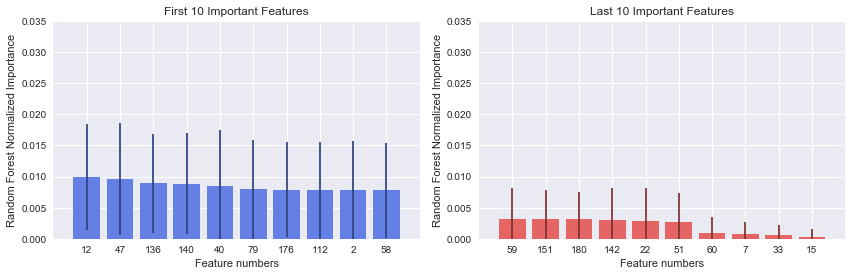

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
imp_std = np.std([est.feature_importances_ for est in rf.estimators_], axis=0)
fig = plt.figure(figsize=(12, 4))

gs1 = gridspec.GridSpec(1, 2,height_ratios=[1])

ax1, ax2 = fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1])

ax1.margins(0.05), ax2.margins(0.05) 

ax1.bar(range(10), importances[indices][:10], \
       color="#6480e5", yerr=imp_std[indices][:10], ecolor='#31427e', align="center")

ax2.bar(range(10), importances[indices][-10:], \
       color="#e56464", yerr=imp_std[indices][-10:], ecolor='#7e3131', align="center")

ax1.set_xticks(range(10)), ax2.set_xticks(range(10))

ax1.set_xticklabels(indices[:10]), ax2.set_xticklabels(indices[-10:])

ax1.set_xlim([-1, 10]), ax2.set_xlim([-1, 10])
ax1.set_ylim([0, 0.035]), ax2.set_ylim([0, 0.035])

ax1.set_xlabel('Feature numbers'), ax2.set_xlabel('Feature numbers')
ax1.set_ylabel('Random Forest Normalized Importance') 
ax2.set_ylabel('Random Forest Normalized Importance')

ax1.set_title('First 10 Important Features'), ax2.set_title('Last 10 Important Features')
gs1.tight_layout(fig)
plt.show()

In [ ]:
#correlation analysis (TBD)


**Feature Selection**

Optimal number of features : 176


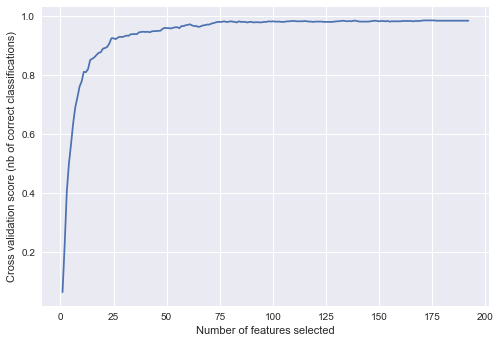

In [19]:
#feature selection exploration
svc = SVC(kernel="linear")
ld = LinearDiscriminantAnalysis();

featureSelector = RFECV(estimator=svc, step = 1, cv=2, scoring='accuracy')

rfecv = featureSelector.fit(train_all, labels)
train_rfecv = rfecv.transform(train_all) 

print("Optimal number of features : %d" % featureSelector.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(featureSelector.grid_scores_) + 1), featureSelector.grid_scores_)
plt.show()

In [ ]:
#selection optimal n number of feature 
svc = SVC(kernel="linear")
rfe = RFE(estimator=svc, n_features_to_select=25, step=1)
train_rfe = rfe.fit_transform(train_all, labels)

train_rfe[1]

In [20]:
#after RFE
naiveBayseScore = list()
for train_index, test_index in kfold.split(train_rfecv):
    X_train, X_test = train_rfecv[train_index], train_rfecv[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    naiveBayse = nb.fit(X_train,y_train)
    naiveBayseScore.append(naiveBayse.score(X_test, y_test))
nb_validation = naiveBayseScore

np.mean(nb_validation)

0.5131313131313131

**The Classifier Belowed is the best one in my submission at the Kaggle competition** 

In [21]:
#After RFE
#Logistic Regression and a GridSearch
params = {'C':[100, 1000], 'tol': [0.001, 0.0001]}
lr_rfe = LogisticRegression(solver='lbfgs', multi_class='multinomial')
gs_rfe = GridSearchCV(lr_rfe, params, scoring=None, refit='True', cv=3) 
gridSearchScore = list()

for train_index, test_index in kfold.split(train_rfecv):
    X_train, X_test = train_rfecv[train_index], train_rfecv[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    GridSearch = gs_rfe.fit(X_train,y_train)
    gridSearchScore.append(GridSearch.score(X_test, y_test))
gs_validation = gridSearchScore

np.mean(gs_validation)

0.97979797979797989

**PCA**

In [22]:
#Priciple Component Analysis
pca = PCA(n_components = 174, svd_solver = 'full',iterated_power='auto')
pca_fit = pca.fit(train_all)
train_pca=pca_fit.transform(train_all)

In [23]:
#After PCA
nb_pca = GaussianNB()
naiveBayseScore = list()
for train_index, test_index in kfold.split(train_pca):
    X_train, X_test = train_pca[train_index], train_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    naiveBayse = nb_pca.fit(X_train,y_train)
    naiveBayseScore.append(naiveBayse.score(X_test, y_test))
    
nb_validation = naiveBayseScore
np.mean(nb_validation)

0.91515151515151505

In [24]:
#After PCA
#linear DiscriminatAnalysis
#shrinkage='auto',
ld_pca = LinearDiscriminantAnalysis(solver='lsqr')
linearDiscScore = list()

for train_index, test_index in kfold.split(train_pca):
    X_train, X_test = train_pca[train_index], train_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    linearDisc = ld_pca.fit(X_train,y_train)
    linearDiscScore.append(linearDisc.score(X_test, y_test))
ld_validation = linearDiscScore

np.mean(ld_validation)

/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


0.97575757575757582

In [ ]:
#After PCA
#KNearestNeighbours
knn_pca = neighbors.KNeighborsClassifier(algorithm='ball_tree',weights= 'distance')
kNNScore = list()
for train_index, test_index in kfold.split(train_pca):
    X_train, X_test = train_pca[train_index], train_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    KnnCl = knn_pca.fit(X_train,y_train)
    kNNScore.append(KnnCl.score(X_test, y_test))    
knn_validation = kNNScore
np.mean(knn_validation)

**The classifier below perform best in cross validation, but it is not the best fot the test data set**

In [25]:
#After PCA
#Logistic Regression and a GridSearch
params = {'C':[100, 1000], 'tol': [0.001, 0.0001]}
lr_pca = LogisticRegression(solver='lbfgs', multi_class='multinomial')
gs_pca = GridSearchCV(lr_pca, params, scoring=None, refit='True', cv=3) 
gridSearchScore = list()

for train_index, test_index in kfold.split(train_pca):
    X_train, X_test = train_pca[train_index], train_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    GridSearch = gs_pca.fit(X_train,y_train)
    gridSearchScore.append(GridSearch.score(X_test, y_test))
gs_validation = gridSearchScore

np.mean(gs_validation)

0.98383838383838373

In [ ]:
#After PCA
#random forest
etcl_pca = ExtraTreesClassifier(n_estimators=500, random_state=0)
ExtraTreeScore = list()

for train_index, test_index in kfold.split(train_pca):
    X_train, X_test = train_pca[train_index], train_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    #fit
    ExtraTree = etcl_pca.fit(X_train,y_train)
    ExtraTreeScore.append(ExtraTree.score(X_test, y_test))

etcl_validation = ExtraTreeScore

np.mean(etcl_validation)

In [26]:
#voting assemble the classifiers
from sklearn.ensemble import VotingClassifier
#('nb_pca',nb_pca), ('ld_pca', ld_pca), ('knn_pca',knn_pca),
eclf1 = VotingClassifier(estimators=[('ld_pca',ld_pca), ('gs_pca', gs_pca)],
                         voting='soft')
VotingClassifierScore = list()
for train_index, test_index in kfold.split(train_pca):
    X_train, X_test = train_pca[train_index], train_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    #fit
    VotingClass = eclf1.fit(X_train,y_train)
    VotingClassifierScore.append(VotingClass.score(X_test, y_test))

np.mean(VotingClassifierScore)

/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:523: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:523: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:523: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:523: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:523: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.97878787878787887

**Separately Train the Classifier Base on different features**
the data has tree different feature, margin, shape and texture. I try to assume that there three kinds of features are independent, and attempt to train them separatly. 

In [27]:
#Priciple Component Analysis
pca = PCA(n_components = 'mle', svd_solver = 'full',iterated_power='auto')
#pca in margin
pca_margin_fit = pca.fit(train_margin)
train_margin_pca=pca_margin_fit.transform(train_margin)
#pca in shape
pca_shape_fit = pca.fit(train_shape)
train_shape_pca = pca_shape_fit.transform(train_shape)
#pca in texture
pca_texture_fit = pca.fit(train_texture)
train_texture_pca = pca_shape_fit.transform(train_texture)


In [ ]:
#feature selection exploration
svc = SVC(kernel="linear")
ld = LinearDiscriminantAnalysis();

featureSelector = RFECV(estimator=svc, step = 1, cv=2, scoring='accuracy')

rfecv = featureSelector.fit(train_margin, labels)
train_margin_rfecv = rfecv.transform(train_margin) 

print("Optimal number of features : %d" % featureSelector.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(featureSelector.grid_scores_) + 1), featureSelector.grid_scores_)
plt.show()

In [ ]:
#feature selection exploration
svc = SVC(kernel="linear")
ld = LinearDiscriminantAnalysis();

featureSelector = RFECV(estimator=svc, step = 1, cv=2, scoring='accuracy')

rfecv = featureSelector.fit(train_shape, labels)
train_shape_rfecv = rfecv.transform(train_shape)

print("Optimal number of features : %d" % featureSelector.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(featureSelector.grid_scores_) + 1), featureSelector.grid_scores_)
plt.show()

In [ ]:
#feature selection exploration
svc = SVC(kernel="linear")
ld = LinearDiscriminantAnalysis();

featureSelector = RFECV(estimator=svc, step = 1, cv=2, scoring='accuracy')

rfecv = featureSelector.fit(train_texture, labels)
train_texture_rfecv = rfecv.transform(train_texture) 

print("Optimal number of features : %d" % featureSelector.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(featureSelector.grid_scores_) + 1), featureSelector.grid_scores_)
plt.show()

In [ ]:
train_two = np.concatenate((train_margin_pca, train_texture_pca),axis = 1)

In [ ]:
params = {'C':[100, 1000], 'tol': [0.001, 0.0001]}
lr_pca = LogisticRegression(solver='lbfgs', multi_class='multinomial')
gs_pca = GridSearchCV(lr_pca, params, scoring=None, refit='True', cv=3) 
gridSearchScore = list()

for train_index, test_index in kfold.split(train_two):
    X_train, X_test = train_two[train_index], train_two[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    GridSearch = gs_pca.fit(X_train,y_train)
    gridSearchScore.append(GridSearch.score(X_test, y_test))
gs_validation = gridSearchScore

np.mean(gs_validation)

In [ ]:
#After PCA
#KNearestNeighbours
knn_pca = neighbors.KNeighborsClassifier(algorithm='ball_tree',weights= 'distance')
kNNScore = list()
for train_index, test_index in kfold.split(train_texture_pca):
    X_train, X_test = train_texture_pca[train_index], train_texture_pca[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    KnnCl = knn_pca.fit(X_train,y_train)
    kNNScore.append(KnnCl.score(X_test, y_test))    
knn_validation = kNNScore
np.mean(knn_validation)

**Test the data in test set**

In [ ]:
test = scaler.transform(test)
test_rfe= rfecv.transform(test)
test_predictions = eclf1.predict_proba(test_pca)

log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

test_predictions = eclf1.predict(test)

acc = accuracy_score(, test_predictions)

acc

In [ ]:
len(train_rfecv[0])
len(test[0])

In [ ]:
test = scaler.transform(test)
test_rfe = rfecv.transform(test)
test_predictions = gs_rfe.predict_proba(test_rfe)

submission = pd.DataFrame(test_predictions, columns=classes)
submission.insert(0, 'id', test_ids)
submission.reset_index()
submission.set_index('id', inplace=True)
fp = open('submit.csv', 'w')
fp.write(submission.to_csv())
print('Finished writing submission')
submission.tail()